# Lab Assigment 1 Q&A Candies
<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>

In [1]:
#imports and line magic to make the notebook work

%pip install --upgrade pip
%pip install opencv-python
%pip install matplotlib
%pip install sympy
%pip install pandas
%pip install ipympl



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sympy
from sympy import * 
import pandas as pd
from scipy.spatial.distance import pdist

## Intrinsic calibration

[Rodrigues Ref](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#void%20Rodrigues(InputArray%20src,%20OutputArray%20dst,%20OutputArray%20jacobian))


[Extrinsic](https://stackoverflow.com/questions/55220229/extrinsic-matrix-computation-with-opencv)
[Size of Squares](https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size)

# Scaling
This implementation relies on scaling the object point matriz so that it represent the actual size of the printed checkboard. 

Another possible implementation, would envolve calculating the average pixel distace between the corners and divide that by the size of the squares giving us a average pixel to lenght unit ratio (this would be a lot more ??suscetipble?? to radial distortion and off focus plane objects)

In [126]:
def calibration(img, printen=False, unit='mm'):
    # tuple that says the grid size (note these are interior corners)
    grid_size = (7,4) 
    # Spacing between squares (from images)
    if (unit == 'm'):
        checker_size = 22e-3 # in m
    else : checker_size = 22 # in mm

    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) and scale it with the side of the square
    objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
    objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)*checker_size # Scale point acording to checker_size

    # This assures the translation matrix is properly scaled to the correct size so we dont use a pixel to mm ratio

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.


    if printen:
        plt.subplot(1,2,1)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Original')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        if printen: cv.drawChessboardCorners(img, grid_size, corners2, ret)
    if printen:
        plt.subplot(1,2,2)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected')
        plt.show()

    
    p_array = np.array(imgpoints)
    p_array.shape = (2,len(imgpoints[0]))
    
    if printen:
        print(f"Average Distance between corners: {pdist(p_array)} pix \nPixel to {unit} Ratio : {pdist(p_array)/checker_size} pix/{unit} ")
    
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    rmtx, jacobian = cv.Rodrigues(rvecs[0])
    if printen:
        print(f" Intrinsic Matrix :")
        pprint(sympy.Matrix(mtx).evalf(3))
        print(f" Distorcion Coefficients :")
        pprint(sympy.Matrix(dist).evalf(3))
        print(f"\n Rotation Vector : ")
        pprint(sympy.Matrix(rvecs[0]).evalf(3))
        print(f"\n Rotation Matrix (from cv.Rodrigues): ")
        pprint(sympy.Matrix(rmtx).evalf(3))
        print(f"\n Translation Matrix : ")
        pprint(sympy.Matrix(tvecs[0]).evalf(3))

    return 0


Loading Image data/IntrinsicCalibration/calib_img_3.png


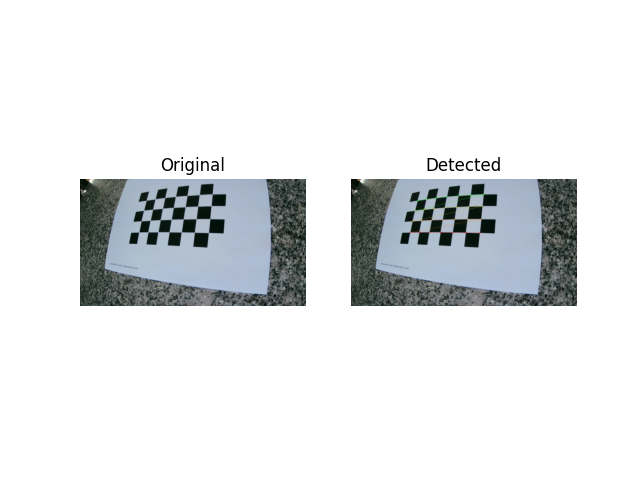

Average Distance between corners: [763.52287414] pix 
Pixel to mm Ratio : [34.70558519]  
 Intrinsic Matrix :
⎡1.25e+3     0     960.0⎤
⎢                       ⎥
⎢   0     1.27e+3  671.0⎥
⎢                       ⎥
⎣   0        0      1.0 ⎦
 Distorcion Coefficients :
[-0.276  -0.185  -0.0129  0.00897  0.396]

 Rotation Vector : 
⎡-0.47 ⎤
⎢      ⎥
⎢-0.238⎥
⎢      ⎥
⎣ -3.0 ⎦

 Rotation Matrix (from cv.Rodrigues): 
⎡-0.947   0.122   0.296⎤
⎢                      ⎥
⎢-0.0733  -0.983  0.169⎥
⎢                      ⎥
⎣ 0.312   0.138   0.94 ⎦

 Translation Matrix : 
⎡23.7 ⎤
⎢     ⎥
⎢-36.7⎥
⎢     ⎥
⎣220.0⎦


In [128]:
images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_3.png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    calibration(img, printen=True)


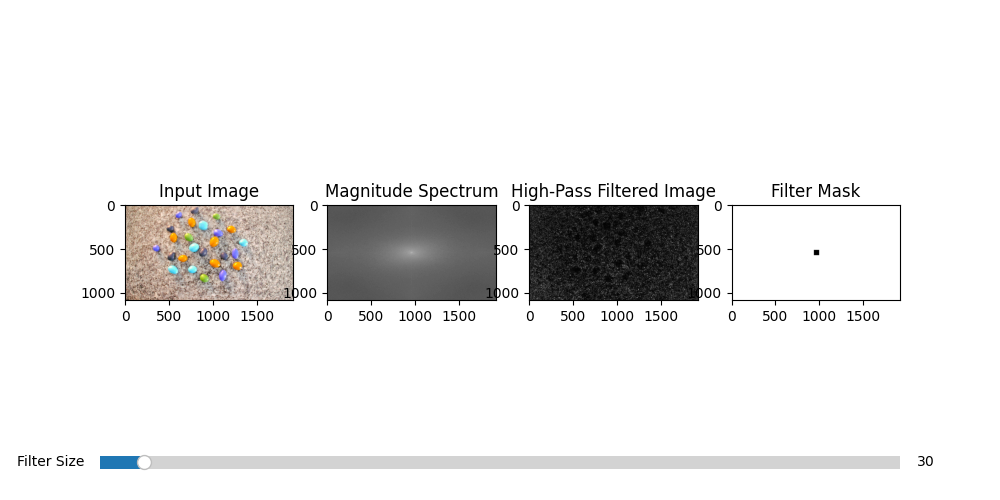

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider

%matplotlib widget

def frequency_filter(image):
    # Convert image to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Fourier transform
    f = np.fft.fft2(img)

    # Shift origin to center
    fshift = np.fft.fftshift(f)

    # Magnitude spectrum
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Create figure with subplots
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    # Plot input image
    axs[0].imshow(image)
    axs[0].set_title('Input Image')

    # Plot magnitude spectrum
    axs[1].imshow(magnitude_spectrum, cmap='gray')
    axs[1].set_title('Magnitude Spectrum')

    # Plot high-pass filtered image
    img_filtered = apply_filter(fshift, img.shape, 30)
    axs[2].imshow(img_filtered, cmap='gray')
    axs[2].set_title('High-Pass Filtered Image')

    # Plot filter mask
    mask = create_mask(img.shape, 30)
    axs[3].imshow(mask, cmap='gray')
    axs[3].set_title('Filter Mask')

    # Add slider for filter size
    slider_ax = fig.add_axes([0.1, 0.05, 0.8, 0.05])
    slider = Slider(slider_ax, 'Filter Size', valmin=0, valmax=min(img.shape)//2, valinit=30)

    # Update plot when slider is changed
    def update(val):
        # Update filter size
        filter_size = int(slider.val)

        # Update high-pass filtered image and filter mask
        img_filtered = apply_filter(fshift, img.shape, filter_size)
        mask = create_mask(img.shape, filter_size)

        # Update plot
        axs[2].imshow(img_filtered, cmap='gray')
        axs[3].imshow(mask, cmap='gray')
        plt.draw()

    # Connect slider to update function
    slider.on_changed(update)

    # Show plot
    plt.show()

def apply_filter(fshift, shape, filter_size):
    # High pass filter
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = create_mask(shape, filter_size)

    # Apply mask
    fshift_filtered = fshift * mask

    # Shift origin back to corner
    f_filtered = np.fft.ifftshift(fshift_filtered)

    # Inverse Fourier transform
    img_filtered = np.fft.ifft2(f_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

def create_mask(shape, filter_size):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-filter_size:crow+filter_size, ccol-filter_size:ccol+filter_size] = 0
    return mask


img = cv2.imread('data/GreyBackground/calib_img_4.png')
frequency_filter(img)
